## Experiment Setup

- Wofs LS5, full history query
- Tile -9 -18, chunk (8,2)
- Image Properties
    - 4000x4000 single band uint8
    - Chunk size 256x256
    - No pixel differencing applied before compressing
    - Format comparion
        - LZW with GDAL XML metadata
        - ZIP (level 9) with GeoTiff only metadata
- 1416 time slices
- Access one chunk from each time slice
- M5.xlarge instance 4 cores 16G ram
- Chunk with largest compressed size was chosen
- S3 bucket and EC2 both in Sydney region
- Data location
    - LZW: http://dea-public-data.s3-website-ap-southeast-2.amazonaws.com/?prefix=wofs-test/LS5_TM_WATER/-9_-18/
    - ZIP: http://dea-public-data.s3-website-ap-southeast-2.amazonaws.com/?prefix=bench-data/LS5_TM_WATER/-9_-18/

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pickle
from utils import bench

## Load data

In [2]:
files = ['./results/M5XL_LZW_-9_-18b8_2B1__01_001.pickle',
 './results/M5XL_ZIP_-9_-18b8_2B1__01_001.pickle']
d_lzw, d_zip = [pickle.load(open(file, 'rb')) for file in files]
sts = [bench.unpack_stats(d,ms=True) for d in [d_lzw, d_zip]]

## Comparison LZW vs ZIP 

-----------------------------------------------------------------------------------------------
Tile: (-9,-18)@8_2#1                           | Tile: (-9,-18)@8_2#1
   - blocks  : 256x256@uint8                   |    - blocks  : 256x256@uint8
   - nthreads: 1                               |    - nthreads: 1
   - LZW + GDAL XML                            |    - ZIP + GeoTiff only
-----------------------------------------------------------------------------------------------
                                               | 
Files read             : 1416                  | Files read             : 1416
Total data bytes       : 10,654,031            | Total data bytes       : 9,687,887
  (excluding headers)                          |   (excluding headers)
Bytes per chunk        : 7524 [5557..17894]    | Bytes per chunk        : 6842 [5042..15434]
                                               | 
Time:                                          | Time:
 per tile:                             

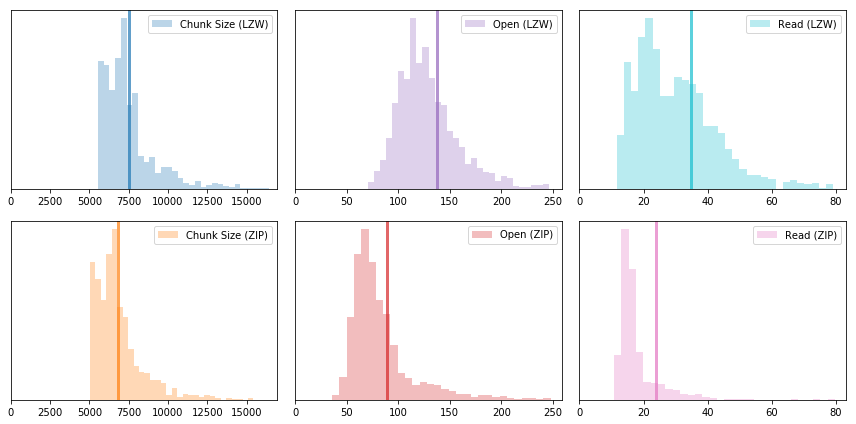

In [3]:
reports = (bench.gen_stats_report(d_lzw, 'LZW + GDAL XML'),
           bench.gen_stats_report(d_zip, 'ZIP + GeoTiff only'))
print(bench.join_reports(*reports))
fig = plt.figure(figsize=(12,6))
bench.plot_comparison(fig, sts, names=['LZW', 'ZIP'], threshs=[17000, 250, 80])

## Analysis

First off it should be understood that we are conflating compression regime and metadata format in this comparison. But comparing across 4 different combinations of the two is too painful. Besides open performance should not be affected by compression settings, only by header size, on the other hand read performance should be affected by compression but not by metadata format.

- ZIP (DEFLATE) produces about 9% smaller chunks (saves S3 costs)

- Smaller header size results in significant speed up of `open` operation
  - 35% reduction in average `open` latency, from 137.5 to 89.2 ms

- Smaller chunks translate into better `read` performance
  - 31% reduction in average `read` latency, from 34.8 down to 23.9 ms 



## Appendix

Following command was used to produce files in `ZIP` dataset:

```bash
gdal_translate \
    -co COMPRESS=DEFLATE \
    -co ZLEVEL=9 \
    -co PREDICTOR=1 \
    -co TILED=YES \
    -co BLOCKXSIZE=256 \
    -co BLOCKYSIZE=256 \
    -co PROFILE=GeoTiff \
    "${src}" "${dst}"
```